In [55]:
import pandas as pd

df = pd.read_csv('../data/sales.csv')
df.dropna(subset=['price'], inplace=True)

In [56]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [57]:
class Cost_Transformer(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

In [58]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [59]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [60]:
X = train_raw[features]
y = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

# 1. train_test_split

In [61]:
from sklearn.model_selection import train_test_split

**Example:** Split training data in to new training data and validation data.

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size=0.2, 
                                                      random_state=2019)

**Example:** Find the best **alpha** for Lasso using **validation score**.

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [64]:
alphas = range(1, 30)
mse = []
for alpha in alphas:
    steps = [('ctf', Cost_Transformer()),
             ('poly', PolynomialFeatures(degree=30)),
             ('rescale', MinMaxScaler()),
             ('lr', Lasso(alpha=alpha, max_iter=100000))]
    model = Pipeline(steps)
    model = model.fit(X_train, y_train)
    mse.append(mean_squared_error(y_valid, model.predict(X_valid)))

In [65]:
import matplotlib.pylab as plt
%matplotlib inline

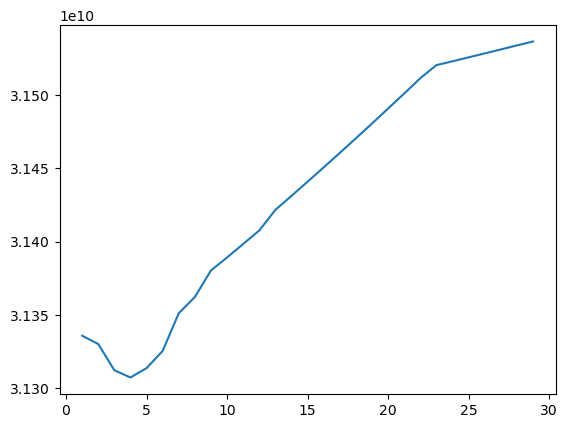

In [66]:
plt.plot(alphas, mse)

<font color='red'>Question:</font> What are training, validation, and testing data for? Why don't we directly use testing score/loss to find the best **alpha**?

In [67]:
#Training data are used for fitting the coefficients for model in a given (set) of hyperparameter.
#Validation data are used for selecting the best hyperparameter (set) for the model.
#Test data are used for testing the prediction power of the trained model.
#Both the training and validation data are used for training the model, the testing data can't not be used in the training.

# 2. K-fold Cross Validation

<font color='red'>Assignment:</font> Use **KFold** instead of **train_test_split** to find the best **alpha**. Please note that X is a DataFrame rather than Numpy Array. Our solution will be a little different from the example in Sklearn tutorial. You will need **iloc** here.

In [68]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=5, shuffle=True, random_state=2022)

"""
for i, (train_index, test_index) in enumerate(kf.split(range(len(X_train)))):
    print(f"Fold {i}:")
    print(f"  Train: {len(train_index)}")
    print(f"  Test:  {len(test_index)}")
"""

alphas = range(1, 30)
mse = []
for alpha in alphas:
    steps = [('ctf', Cost_Transformer()),
             ('poly', PolynomialFeatures(degree=30)),
             ('rescale', MinMaxScaler()),
             ('lr', Lasso(alpha=alpha, max_iter=100000))]
    mse_alpha = []
    for i, (train_index, valid_index) in enumerate(kf.split(range(len(X)))):
        model = Pipeline(steps)
        model = model.fit(X.iloc[train_index], y.iloc[train_index])
        mse_alpha.append(mean_squared_error(y.iloc[valid_index], model.predict(X.iloc[valid_index])))
    #mse.append(sum(mse_alpha)/len(mse_alpha))
    mse.append(mse_alpha)

In [69]:
import statistics
mse_mean = []
for i in range(len(alphas)):
    mse_mean.append(statistics.mean(mse[i]))

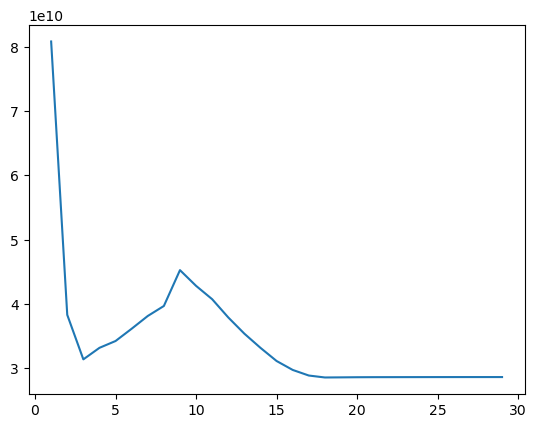

In [70]:
plt.plot(alphas, mse_mean)

<font color='red'>Question:</font> What is the difference between **KFold** and **train_test_split**? What is the advantages and disadvanteges of k-fold cross validation?

In [71]:
# In contrast to train_test_split in which a subset of the data is set to be used as validation data while the other to be used 
# as training data; KFold splits the data to n folds and repeats the train-validate process n times where in each time one 
# fold of the data is used as validation data while the other is used as training data.
#
#The advantage of k-fold is reduce the variance from the spliting of data, so the estimation of the function loss is more 
#reliable. The disadvantage is the computation time is increased k times.

# 3. GridSearchCV

<font color='red'>Assignment:</font> By now, we have only tuned the value of **alpha**. Actually, **degree** in **PolynomialFeatures** is also a hyper parameter. Can we find the best values for both of them? You can try to use **GridSearchCV**, and also **make_scorer**.

In [80]:
from sklearn.model_selection import RepeatedKFold,GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.linear_model import Ridge

steps = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures()),
         ('rescale', MinMaxScaler()),
         ('ri', Ridge(max_iter=10000))]
model = Pipeline(steps)

scorer_method = make_scorer(mean_squared_error)

#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
kf = KFold(n_splits=5, shuffle=True, random_state=2022)
#lasso_alphas = np.linspace(0, 30, 31)
#poly_degree = np.linspace(1, 30, 30)
#lasso_alphas = np.linspace(1, 30, 30)
ridge_alphas = np.linspace(1, 30, 30)
poly_degree = range(1, 30)
grid = dict()
#grid['lr__alpha'] = lasso_alphas 
grid['ri__alpha'] = ridge_alphas 
grid['poly__degree'] = poly_degree 

search = GridSearchCV(model, param_grid = grid, scoring = scorer_method, \
                      cv = kf, n_jobs = -1, error_score = np.NaN).fit(X, y)

print('MAE: %.5f' % search.best_score_)
print('Config: %s' % search.best_params_)

MAE: 33907924260.98915
Config: {'poly__degree': 29, 'ri__alpha': 5.0}


In [81]:
y_test_pred = search.predict(X_test)
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))

test MSE: 5.33e+10
